In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math

In [2]:
# load words
words = open("names.txt").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
DELIMITER = "."
chars = sorted(set(list("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi.update({".": 0})
itos = {i: s for s, i in stoi.items()}


# pretty print
skip_index = 27
items = [(i, itos.get(i)) for i in range(len(itos)) if i != skip_index]

first_col = items[: len(items) // 2 + len(items) % 2]
second_col = items[len(items) // 2 + len(items) % 2 :]

for first, second in zip(first_col, second_col + [(None, None)]):
    first_str = f"{first[0]:>2} -> {first[1]}"
    second_str = f"{second[0]:>2} -> {second[1]}" if second[0] is not None else ""
    print(f"{first_str}\t\t{second_str}")

 0 -> .		14 -> n
 1 -> a		15 -> o
 2 -> b		16 -> p
 3 -> c		17 -> q
 4 -> d		18 -> r
 5 -> e		19 -> s
 6 -> f		20 -> t
 7 -> g		21 -> u
 8 -> h		22 -> v
 9 -> i		23 -> w
10 -> j		24 -> x
11 -> k		25 -> y
12 -> l		26 -> z
13 -> m		


Build the dataset

In [4]:
CONTEXT_LENGTH = 4
random.seed(42)
random.shuffle(words)  # shuffles in place


def build_dataset(words: list[str]) -> (torch.Tensor, torch.Tensor):
    X, Y = [], []

    for word in words:
        context = [0] * CONTEXT_LENGTH
        for char in word + DELIMITER:
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


splits = int(0.8 * len(words)), int(0.9 * len(words))

X_train, Y_train = build_dataset(words[: splits[0]])
X_dev, Y_dev = build_dataset(words[splits[0] : splits[1]])
X_test, Y_test = build_dataset(words[splits[1] :])

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [5]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn([27, 10], generator=g)
W1 = torch.randn([40, 512], generator=g) * 0.01
b1 = torch.randn([512], generator=g) * 0.01
W2 = torch.randn([512, 27], generator=g) * 0.01
b2 = torch.randn([27], generator=g) * 0.01
parameters = [C, W1, b1, W2, b2]

# add gradients
for p in parameters:
    p.requires_grad = True

In [6]:
print(f"Number of parameters in model: {sum(p.nelement() for p in parameters):,}")

Number of parameters in model: 35,113


Training

In [7]:
BATCH_SIZE = 128
EPOCHS = 500_000
LR_START = 0.3
LR_END = 0.005
K = 9  # LR decay rate

lri = []
lossi = []
stepi = []

for i in range(EPOCHS):
    batch_indices = torch.randint(0, X_train.shape[0], (BATCH_SIZE,))

    # forward pass
    embeddings = C[X_train[batch_indices]]
    h = torch.tanh(embeddings.view(-1, 40) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[batch_indices])

    for p in parameters:
        p.grad = None
    loss.backward()
    lrs = []

    lr = LR_END + (LR_START - LR_END) * math.exp(-K * (i / EPOCHS))
    for p in parameters:
        p.data += -lr * p.grad

    # tracking
    stepi.append(i)
    lri.append(lr)
    lossi.append(loss.log10().item())

    if (i % (EPOCHS // 10) == 0) | (i == EPOCHS - 1):
        print(f"Epoch {i:6}: loss = {loss:6f}, lr = {lr:.6f}")

Epoch      0: loss = 3.295875, lr = 0.300000
Epoch  50000: loss = 2.014006, lr = 0.124938
Epoch 100000: loss = 2.108584, lr = 0.053763
Epoch 150000: loss = 1.929190, lr = 0.024826
Epoch 200000: loss = 1.995093, lr = 0.013060
Epoch 250000: loss = 2.067602, lr = 0.008277
Epoch 300000: loss = 1.986612, lr = 0.006332
Epoch 350000: loss = 1.970319, lr = 0.005542
Epoch 400000: loss = 1.890660, lr = 0.005220
Epoch 450000: loss = 2.171172, lr = 0.005090
Epoch 499999: loss = 2.038245, lr = 0.005036


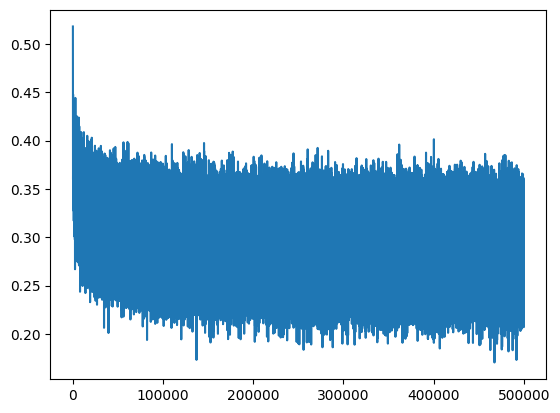

In [8]:
plt.plot(stepi, lossi)

In [9]:
# loss on whole training set
embeddings = C[X_train]
h = torch.tanh(embeddings.view(-1, 40) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print(loss)

tensor(1.9448, grad_fn=<NllLossBackward0>)


In [10]:
# loss on dev set
embeddings = C[X_dev]
h = torch.tanh(embeddings.view(-1, 40) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
print(loss)

tensor(2.0509, grad_fn=<NllLossBackward0>)


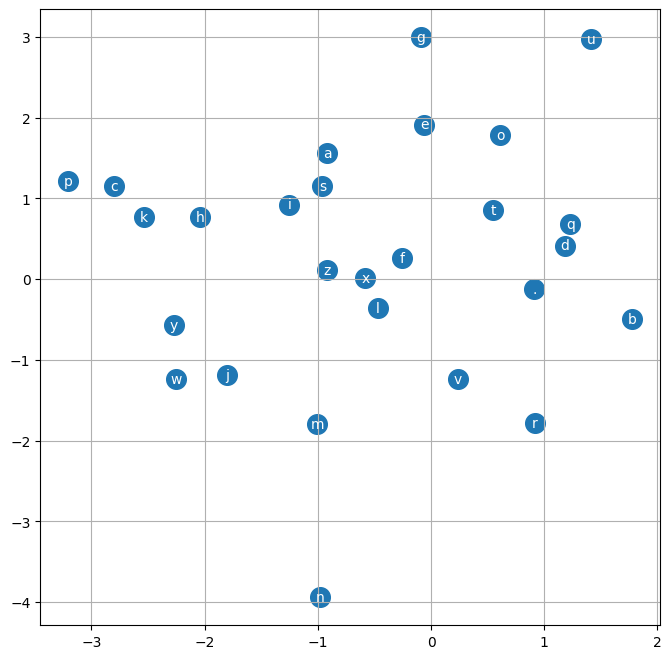

In [11]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")

Sample

In [12]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * CONTEXT_LENGTH
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

montaimyan.
seev.
ndhe.
alexzamariengra.
grazeem.
meliah.
miloparikelle.
naxarielle.
malaia.
noshruvigah.
miel.
kindreth.
konnon.
casuba.
gedtryyah.
faeha.
kayshawn.
yamihal.
salynn.
unizal.
